#### Dowload the historical monthly stock price data for Microsoft (MSFT), Proctor and Gamble (PG), and the S&P 500 (^GSPC) from Jan 1 2010 onwards. 

Calculate a series of returns for all. Also calculate the mean and standard deviance of returns. The monthly returns are calculated from the last day of the previous month until the date of the current month.

In [87]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

tickers = ["MSFT", "PG", "^GSPC"]
start_date = "2009-12-31" # include some data before 2010 to get the first return for Jan 2010
end_date   = "2024-12-31"

# Download data from Yahoo Finance with adjusted prices
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)

# We only need the 'Close' prices here. 
close = data["Close"].copy()

# Resample to monthly frequency by taking the last observation of each month
monthly_close = close.resample('ME').last()

# Compute Monthly Returns percentage returns. For each symbol, Return(t) = Close(t)/Close(t-1) - 1.
monthly_returns = monthly_close.pct_change().dropna()

# Rename columns for convenience
monthly_returns.columns = ["MSFT", "PG", "SP500"]

# Summary statistics (mean and std) for each symbol
mean_returns = monthly_returns.mean()
std_returns  = monthly_returns.std()

print("Mean Monthly Returns:")
print(monthly_returns.head())


Mean Monthly Returns:
                MSFT        PG     SP500
Date                                    
2010-01-31 -0.075459  0.022463 -0.036974
2010-02-28  0.022146  0.028107  0.028514
2010-03-31  0.021625 -0.000158  0.058796
2010-04-30  0.042677 -0.009983  0.014759
2010-05-31 -0.151394 -0.017213 -0.081976


#### Estimate the full-sample CAPM betas (and their standard errors) of MSFT and PG.
For simplicity, we will assume that the risk free rate is 0.

In [ ]:
# Estimate CAPM Betas
# In a standard CAPM regression: 
#   (Ri - Rf) = alpha + beta * (Rm - Rf) + error,
# Here we assume Rf = 0 for simplicity, so: 
#   Ri = alpha + beta * Rm + error

# We'll define a function to get the OLS regression results
def capm_regression(asset_returns, market_returns):
    X = sm.add_constant(market_returns.values)
    y = asset_returns.values
    model = sm.OLS(y, X)
    results = model.fit()
    return results

results_msft = capm_regression(monthly_returns["MSFT"], monthly_returns["SP500"])
results_pg   = capm_regression(monthly_returns["PG"],   monthly_returns["SP500"])

# Extract beta, beta standard error from the results
beta_msft      = results_msft.params[1]
beta_msft_se   = results_msft.bse[1]
beta_pg        = results_pg.params[1]
beta_pg_se     = results_pg.bse[1]

print("\nCAPM Beta Estimates:")
print(f"MSFT Beta: {beta_msft:.4f} (SE: {beta_msft_se:.4f})")
print(f"PG Beta:   {beta_pg:.4f} (SE: {beta_pg_se:.4f})")


CAPM Beta Estimates:
MSFT Beta: 0.9887 (SE: 0.0824)
PG Beta:   0.4221 (SE: 0.0706)


#### Calculate the returns to a portfolio of MSFT and PG that rebalances to 50% / 50% weights at the start of January. 
Assume that we start with $2000 in the portfolio. $1000 in MSFT and $1000 in PG. Reweighting is only done once a year right after calculating the end of december porfolio value. This can be seen as an annual Jan 1 rebalancing.

In [ ]:
# Construct the 50/50 Annual-Rebalanced Portfolio of MSFT & PG

# We want to hold 50% MSFT and 50% PG at the start of each January, and let them 
# drift throughout the year without rebalancing again until next January.

# Let's define a small helper to check "Is this month January?"
def is_january(dt):
    return dt.month == 1

returns_df = monthly_returns.copy()

# For the first month in the series, calculate the return based on a 50/50 portfolio on 1 Jan 2010
# We'll assume that we start with $2000 in the portfolio
# We'll also assume that we can buy fractional shares

# Add a column for MSFT, PG and Porfolio cumulative. Every January, we will rebalance the portfolio before calculating the cumulative value
returns_df["CUM_MSFT"] = 1000 * (1 + returns_df["MSFT"])
returns_df["CUM_PG"] = 1000 * (1 + returns_df["PG"])

# Iterate over the rows to calculate cumulative returns
for i in range(1, len(returns_df)):
    if is_january(returns_df.index[i]):
        # Rebalance at the start of each January
        total_value = returns_df.loc[returns_df.index[i-1], "CUM_MSFT"] + returns_df.loc[returns_df.index[i-1], "CUM_PG"]
        returns_df.loc[returns_df.index[i], "CUM_MSFT"] = total_value * 0.5 * (1 + returns_df.loc[returns_df.index[i], "MSFT"])
        returns_df.loc[returns_df.index[i], "CUM_PG"] = total_value * 0.5 * (1 + returns_df.loc[returns_df.index[i], "PG"])
    else:
        # Continue with the cumulative return calculation
        returns_df.loc[returns_df.index[i], "CUM_MSFT"] = returns_df.loc[returns_df.index[i-1], "CUM_MSFT"] * (1 + returns_df.loc[returns_df.index[i], "MSFT"])
        returns_df.loc[returns_df.index[i], "CUM_PG"] = returns_df.loc[returns_df.index[i-1], "CUM_PG"] * (1 + returns_df.loc[returns_df.index[i], "PG"])

returns_df["CUM_PORTFOLIO"] = returns_df["CUM_MSFT"] + returns_df["CUM_PG"]
returns_df["PORTFOLIO"] = returns_df["CUM_PORTFOLIO"].pct_change()
# Replace the NaN at index 0 with the percentage change from 2000 to the first CUM_PORTFOLIO value
returns_df.loc[returns_df.index[0], "PORTFOLIO"] = (
    (returns_df.loc[returns_df.index[0], "CUM_PORTFOLIO"] - 2000) / 2000
)

portfolio_mean = returns_df["PORTFOLIO"].mean()
portfolio_std = returns_df["PORTFOLIO"].std()
print(f"Portfolio Mean: {portfolio_mean:.4f}")
print(f"Portfolio Std: {portfolio_std:.4f}")


Portfolio Mean: 0.0137
Portfolio Std: 0.0427


In [82]:
print(returns_df[["CUM_PORTFOLIO", "PORTFOLIO"]])

            CUM_PORTFOLIO  PORTFOLIO
Date                                
2010-01-31    1947.003608  -0.026498
2010-02-28    1996.217208   0.025277
2010-03-31    2016.487655   0.010154
2010-04-30    2047.198209   0.015230
2010-05-31    1876.884393  -0.083194
...                   ...        ...
2024-08-31   19313.829346   0.032999
2024-09-30   19704.856993   0.020246
2024-10-31   18758.875195  -0.048008
2024-11-30   19965.725294   0.064335
2024-12-31   19582.403106  -0.019199

[180 rows x 2 columns]


#### Estimate the CAPM beta and its standard error

In [88]:
results_portfolio = capm_regression(returns_df["PORTFOLIO"], returns_df["SP500"])

# Extract beta, beta standard error from the results
beta_portfolio      = results_portfolio.params[1]
beta_portfolio_se   = results_portfolio.bse[1]

print("CAPM Beta Estimates:")
print(f"Portfolio Beta: {beta_portfolio:.4f} (SE: {beta_portfolio_se:.4f})")

CAPM Beta Estimates:
Portfolio Beta: 0.7091 (SE: 0.0545)


#### Plot cumulative returns for all four investments:
1. MSFT
2. PG
3. SP500
4. Portfolio of MSFT+PG rebalanced annualy

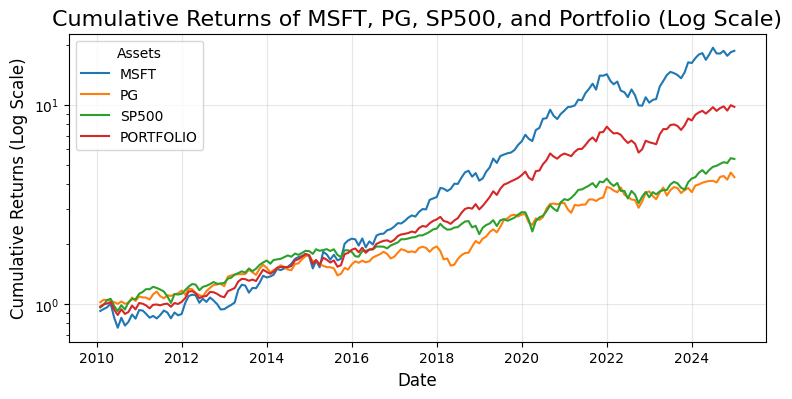

In [90]:
plot_df = returns_df[["MSFT", "PG", "SP500", "PORTFOLIO"]].copy()

# Calculate cumulative returns for each asset
cumulative_returns = (1 + plot_df).cumprod()

# Plot cumulative returns
plt.figure(figsize=(9, 4))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

# Add labels, title, and legend
plt.title("Cumulative Returns of MSFT, PG, SP500, and Portfolio (Log Scale)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns (Log Scale)", fontsize=12)
plt.legend(title="Assets", fontsize=10)
plt.grid(alpha=0.3)

# Set the y-axis to log scale
plt.yscale("log")

# Show the plot
plt.show()

#### Create a table of key statistics

In [85]:
stats_df = pd.DataFrame({
    "Mean Return": [mean_returns["MSFT"], mean_returns["PG"], mean_returns["SP500"], portfolio_mean],
    "Std Dev":     [std_returns["MSFT"],  std_returns["PG"],  std_returns["SP500"],  portfolio_std],
    "Beta":        [beta_msft,           beta_pg,            1,                beta_portfolio],
    "Beta SE":     [beta_msft_se,        beta_pg_se,         np.nan,                beta_portfolio_se],
},
    index=["MSFT", "PG", "SP500", "PORTFOLIO"]
)

print("\nSummary Statistics:")
print(stats_df)


Summary Statistics:
           Mean Return   Std Dev      Beta   Beta SE
MSFT          0.018298  0.062102  0.988669  0.082397
PG            0.009121  0.043380  0.422084  0.070649
SP500         0.010252  0.042003  1.000000       NaN
PORTFOLIO     0.013651  0.042681  0.709149  0.054548


#### Summary and Discussion

From the cumulative return plot, we see that Microsoft (MSFT) generated the highest total growth over the sample, although with more pronounced fluctuations. Procter & Gamble (PG) exhibited more stable performance, but it underperformed MSFT and the S&P 500 in terms of total return. The S&P 500 lies between PG and MSFT. The 50/50 Portfolio of MSFT and PG produced cumulative returns that are higher than S&P500 or PG alone but below MSFT’s results, with volatility and beta that sit between the two. 

Comparing the CAPM beta of the 50/50 porfolio comapared to the individual stocks, it looks like the 50/50 portfolio has a beta almost exactly in the middle of PG and MSFT. This matches the intuition that combining a more volatile, higher-beta stock with a lower-volatility, lower-beta stock should provide “in-between” results. The annual rebalancing likely plays a big role in averaging out the individual betas. Without the rebalancing, the portfolio would, over time, become more MSFT heavy and its beta would start to more closely reflect that of MSFT.

One potential improvement to this exercise would be to incorporate a risk-free rate (using short-term Treasury bills) so that the CAPM beta estimates are not biased by assuming a zero risk-free return. One more potential improvement could be to incorporate dividends in the calculations of the cumulative returns, since this will be better representative of a true "buy-and-hold" investor who reinvests dividends.